In [13]:
# Iris Dataset Novelty Detection Analysis
# Using ECOD, COPOD, and LODA algorithms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Install required packages (uncomment if needed)
# !pip install pyod statsmodels

# Import outlier detection algorithms
from pyod.models.ecod import ECOD
from pyod.models.copod import COPOD  
from pyod.models.loda import LODA



In [5]:
# Import dataset
import statsmodels.api as sm

print("="*60)
print("IRIS DATASET NOVELTY DETECTION ANALYSIS")
print("="*60)

# Load the Iris dataset from statsmodels
iris_data = sm.datasets.get_rdataset("iris", "datasets")
df = iris_data.data.copy()

print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nDataset description:")
print(df.describe())

print("\nSpecies distribution:")
print(df['Species'].value_counts())



IRIS DATASET NOVELTY DETECTION ANALYSIS
Dataset shape: (150, 5)
Dataset columns: ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species']

First 5 rows:
   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object

In [6]:
# Prepare features for analysis
feature_cols = ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']
X = df[feature_cols].values
y_species = df['Species'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeature matrix shape: {X_scaled.shape}")

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

# Initialize outlier detection models
contamination = 0.1  # Assume 10% outliers
models = {
    'ECOD': ECOD(contamination=contamination),
    'COPOD': COPOD(contamination=contamination),
    'LODA': LODA(contamination=contamination)
}

# Dictionary to store results
results = {}




Feature matrix shape: (150, 4)
PCA explained variance ratio: [0.72962445 0.22850762]
Total variance explained: 0.9581



NOVELTY DETECTION ANALYSIS

Training ECOD...
ECOD - Number of outliers detected: 15
ECOD - Outlier percentage: 10.00%

Training COPOD...
COPOD - Number of outliers detected: 15
COPOD - Outlier percentage: 10.00%

Training LODA...
LODA - Number of outliers detected: 15
LODA - Outlier percentage: 10.00%


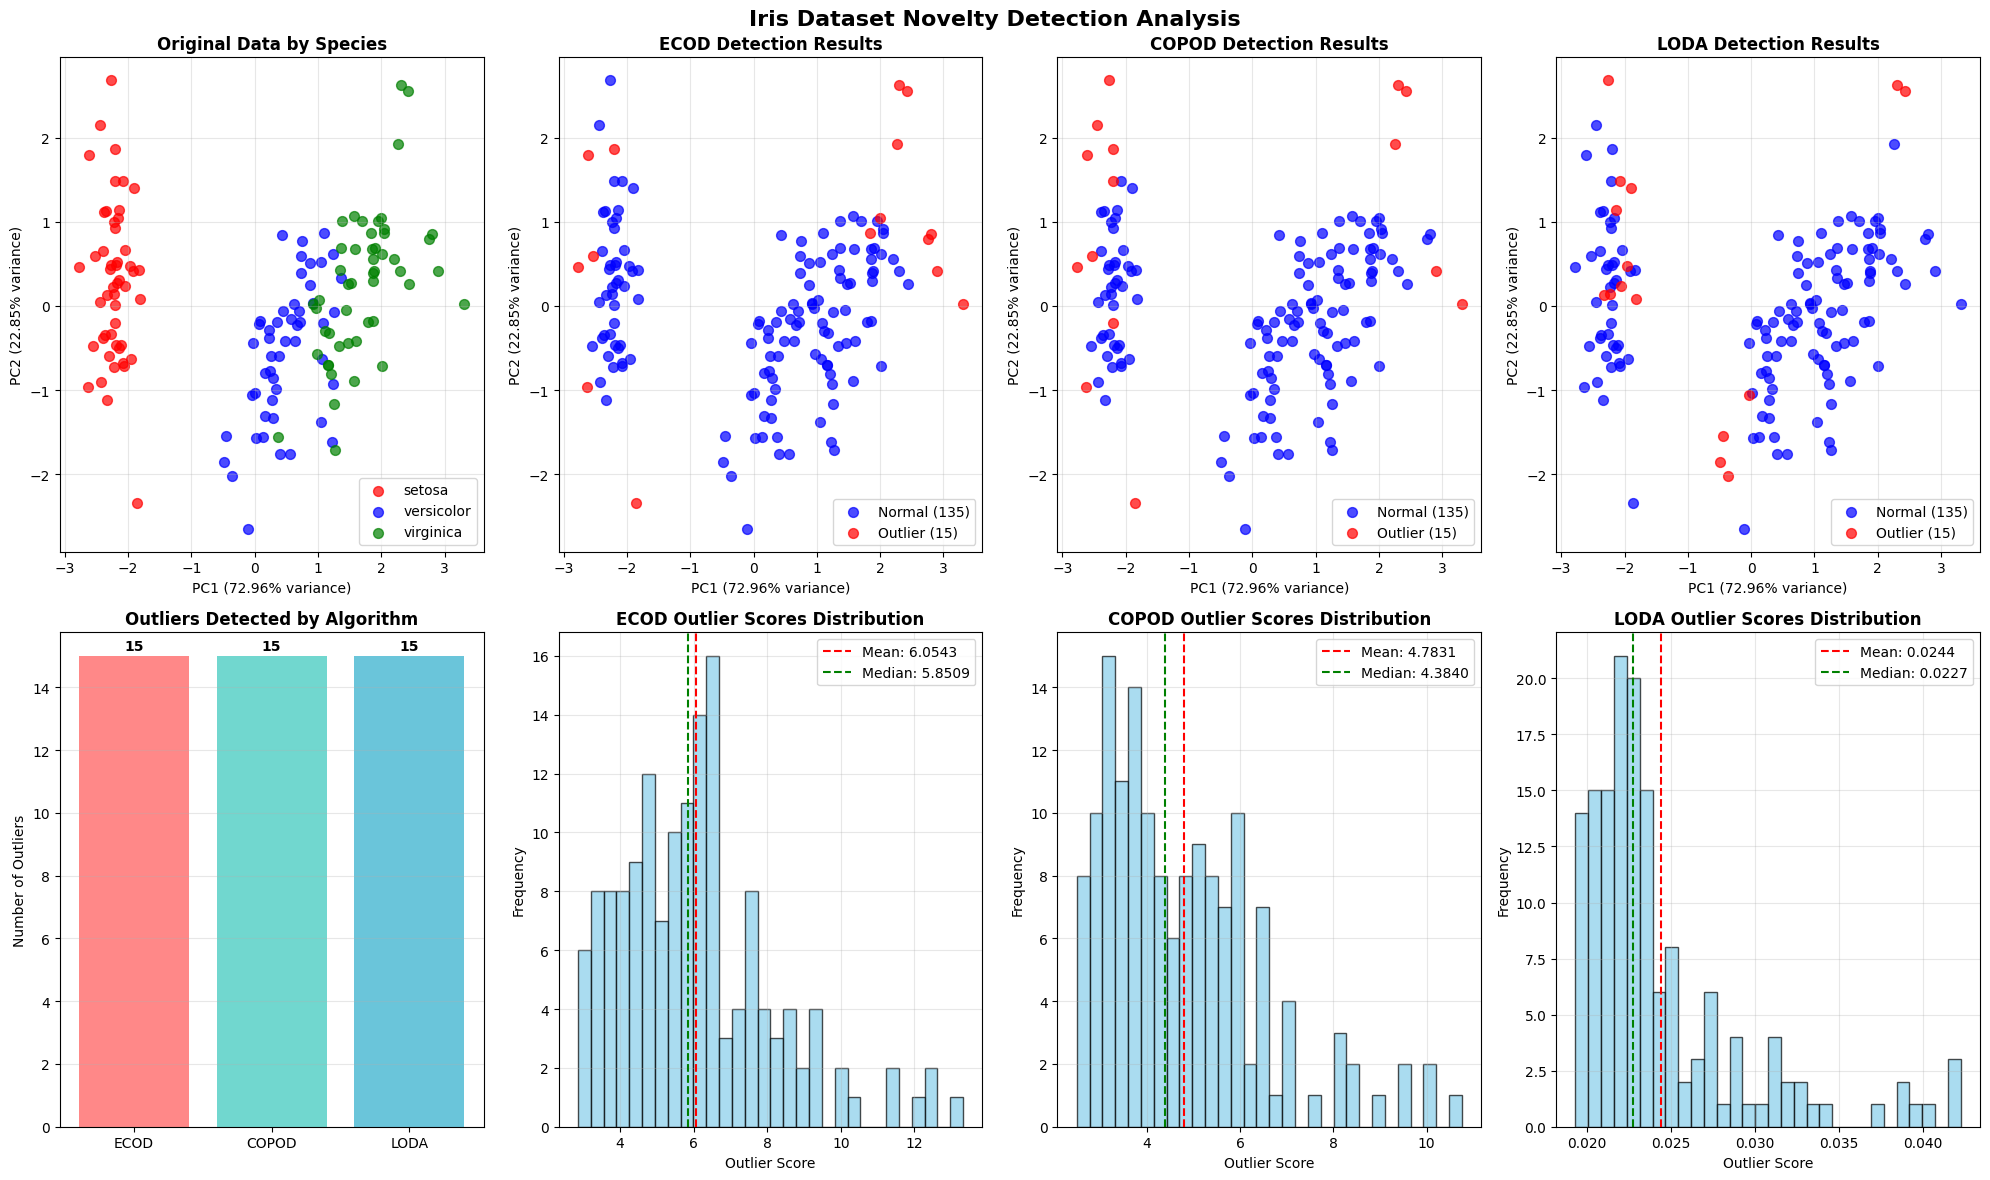

In [7]:
print("\n" + "="*60)
print("NOVELTY DETECTION ANALYSIS")
print("="*60)

# Train models and get predictions
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_scaled)
    
    # Get outlier predictions (1 for outlier, 0 for inlier)
    outlier_pred = model.predict(X_scaled)
    
    # Get outlier scores
    outlier_scores = model.decision_function(X_scaled)
    
    # Store results
    results[name] = {
        'model': model,
        'predictions': outlier_pred,
        'scores': outlier_scores,
        'n_outliers': np.sum(outlier_pred)
    }
    
    print(f"{name} - Number of outliers detected: {results[name]['n_outliers']}")
    print(f"{name} - Outlier percentage: {results[name]['n_outliers']/len(X_scaled)*100:.2f}%")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Iris Dataset Novelty Detection Analysis', fontsize=16, fontweight='bold')

# Original data visualization by species
ax = axes[0, 0]
species_colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'green'}
for species in df['Species'].unique():
    mask = df['Species'] == species
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=species_colors[species], label=species, alpha=0.7, s=50)
ax.set_title('Original Data by Species', fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot results for each algorithm
colors = ['blue', 'red']
labels = ['Normal', 'Outlier']

for i, (name, result) in enumerate(results.items()):
    ax = axes[0, i+1]
    
    for j, (color, label) in enumerate(zip(colors, labels)):
        mask = result['predictions'] == j
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c=color, label=f'{label} ({np.sum(mask)})', alpha=0.7, s=50)
    
    ax.set_title(f'{name} Detection Results', fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot outlier scores distribution
for i, (name, result) in enumerate(results.items()):
    ax = axes[1, i+1]
    
    # Plot histogram of outlier scores
    ax.hist(result['scores'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax.axvline(np.mean(result['scores']), color='red', linestyle='--', 
               label=f'Mean: {np.mean(result["scores"]):.4f}')
    ax.axvline(np.median(result['scores']), color='green', linestyle='--', 
               label=f'Median: {np.median(result["scores"]):.4f}')
    
    ax.set_title(f'{name} Outlier Scores Distribution', fontweight='bold')
    ax.set_xlabel('Outlier Score')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Comparison of algorithms
ax = axes[1, 0]
algorithm_names = list(results.keys())
outlier_counts = [results[name]['n_outliers'] for name in algorithm_names]

bars = ax.bar(algorithm_names, outlier_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax.set_title('Outliers Detected by Algorithm', fontweight='bold')
ax.set_ylabel('Number of Outliers')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, outlier_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



In [8]:
# Create detailed comparison table
print("\n" + "="*60)
print("DETAILED COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Algorithm': list(results.keys()),
    'Outliers_Detected': [results[name]['n_outliers'] for name in results.keys()],
    'Outlier_Percentage': [f"{results[name]['n_outliers']/len(X_scaled)*100:.2f}%" for name in results.keys()],
    'Mean_Score': [f"{np.mean(results[name]['scores']):.4f}" for name in results.keys()],
    'Std_Score': [f"{np.std(results[name]['scores']):.4f}" for name in results.keys()],
    'Min_Score': [f"{np.min(results[name]['scores']):.4f}" for name in results.keys()],
    'Max_Score': [f"{np.max(results[name]['scores']):.4f}" for name in results.keys()]
})

print(comparison_df.to_string(index=False))




DETAILED COMPARISON
Algorithm  Outliers_Detected Outlier_Percentage Mean_Score Std_Score Min_Score Max_Score
     ECOD                 15             10.00%     6.0543    2.1061    2.8585   13.3211
    COPOD                 15             10.00%     4.7831    1.7236    2.4880   10.7589
     LODA                 15             10.00%     0.0244    0.0050    0.0193    0.0423


In [9]:
# Analyze which samples are consistently detected as outliers
print("\n" + "="*60)
print("CONSENSUS ANALYSIS")
print("="*60)

# Create a matrix of predictions
pred_matrix = np.column_stack([results[name]['predictions'] for name in results.keys()])
consensus_outliers = np.sum(pred_matrix, axis=1)

print("Consensus outlier detection:")
print(f"Samples detected as outliers by all 3 algorithms: {np.sum(consensus_outliers == 3)}")
print(f"Samples detected as outliers by 2 algorithms: {np.sum(consensus_outliers == 2)}")
print(f"Samples detected as outliers by 1 algorithm: {np.sum(consensus_outliers == 1)}")
print(f"Samples detected as normal by all algorithms: {np.sum(consensus_outliers == 0)}")

# Show samples detected by all algorithms
if np.sum(consensus_outliers == 3) > 0:
    all_outliers_idx = np.where(consensus_outliers == 3)[0]
    print(f"\nSamples detected as outliers by ALL algorithms (indices): {all_outliers_idx}")
    print("Details of these samples:")
    outlier_details = df.iloc[all_outliers_idx][['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species']]
    print(outlier_details.to_string())




CONSENSUS ANALYSIS
Consensus outlier detection:
Samples detected as outliers by all 3 algorithms: 2
Samples detected as outliers by 2 algorithms: 10
Samples detected as outliers by 1 algorithm: 19
Samples detected as normal by all algorithms: 119

Samples detected as outliers by ALL algorithms (indices): [117 131]
Details of these samples:
     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width    Species
117           7.7          3.8           6.7          2.2  virginica
131           7.9          3.8           6.4          2.0  virginica



SCORE CORRELATION ANALYSIS
Correlation matrix of outlier scores:
         ECOD   COPOD    LODA
ECOD   1.0000  0.9183  0.2765
COPOD  0.9183  1.0000  0.2980
LODA   0.2765  0.2980  1.0000


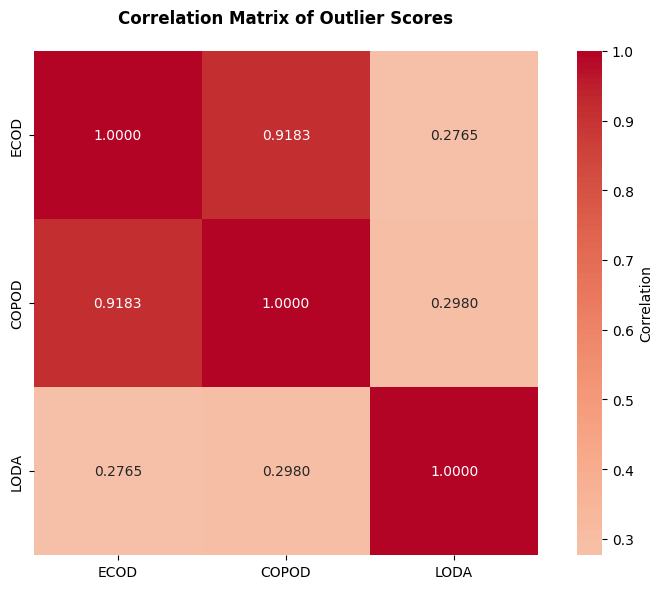

In [10]:
# Create correlation matrix of outlier scores
print("\n" + "="*60)
print("SCORE CORRELATION ANALYSIS")
print("="*60)

score_df = pd.DataFrame({name: results[name]['scores'] for name in results.keys()})
correlation_matrix = score_df.corr()

print("Correlation matrix of outlier scores:")
print(correlation_matrix.round(4))

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.4f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Outlier Scores', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



In [12]:
# Feature importance analysis (for samples detected as outliers)
print("\n" + "="*60)
print("FEATURE ANALYSIS OF OUTLIERS")
print("="*60)

for name in results.keys():
    outlier_mask = results[name]['predictions'] == 1
    if np.sum(outlier_mask) > 0:
        print(f"\n{name} - Feature statistics for detected outliers:")
        outlier_features = df.iloc[outlier_mask][feature_cols]
        normal_features = df.iloc[~outlier_mask][feature_cols]
        
        feature_comparison = pd.DataFrame({
            'Feature': feature_cols,
            'Outlier_Mean': outlier_features.mean().round(4),
            'Normal_Mean': normal_features.mean().round(4),
            'Difference': (outlier_features.mean() - normal_features.mean()).round(4)
        })
        print(feature_comparison.to_string(index=False))

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("- ECOD: Empirical Cumulative Distribution Functions for Outlier Detection")
print("- COPOD: Copula-Based Outlier Detection")  
print("- LODA: Lightweight On-line Detector of Anomalies")


FEATURE ANALYSIS OF OUTLIERS

ECOD - Feature statistics for detected outliers:
     Feature  Outlier_Mean  Normal_Mean  Difference
Sepal.Length        6.3867       5.7830      0.6037
 Sepal.Width        3.3200       3.0281      0.2919
Petal.Length        4.3133       3.6963      0.6170
 Petal.Width        1.4267       1.1741      0.2526

COPOD - Feature statistics for detected outliers:
     Feature  Outlier_Mean  Normal_Mean  Difference
Sepal.Length        5.9400       5.8326      0.1074
 Sepal.Width        3.5267       3.0052      0.5215
Petal.Length        3.0467       3.8370     -0.7904
 Petal.Width        0.8800       1.2348     -0.3548

LODA - Feature statistics for detected outliers:
     Feature  Outlier_Mean  Normal_Mean  Difference
Sepal.Length        5.5267       5.8785     -0.3519
 Sepal.Width        3.3533       3.0244      0.3289
Petal.Length        2.7600       3.8689     -1.1089
 Petal.Width        0.7800       1.2459     -0.4659

ANALYSIS COMPLETE
- ECOD: Empirical Cu


Training Isolation_Forest...
Isolation_Forest - Number of outliers detected: 15
Isolation_Forest - Outlier percentage: 10.00%

Training OneClass_SVM...
OneClass_SVM - Number of outliers detected: 14
OneClass_SVM - Outlier percentage: 9.33%


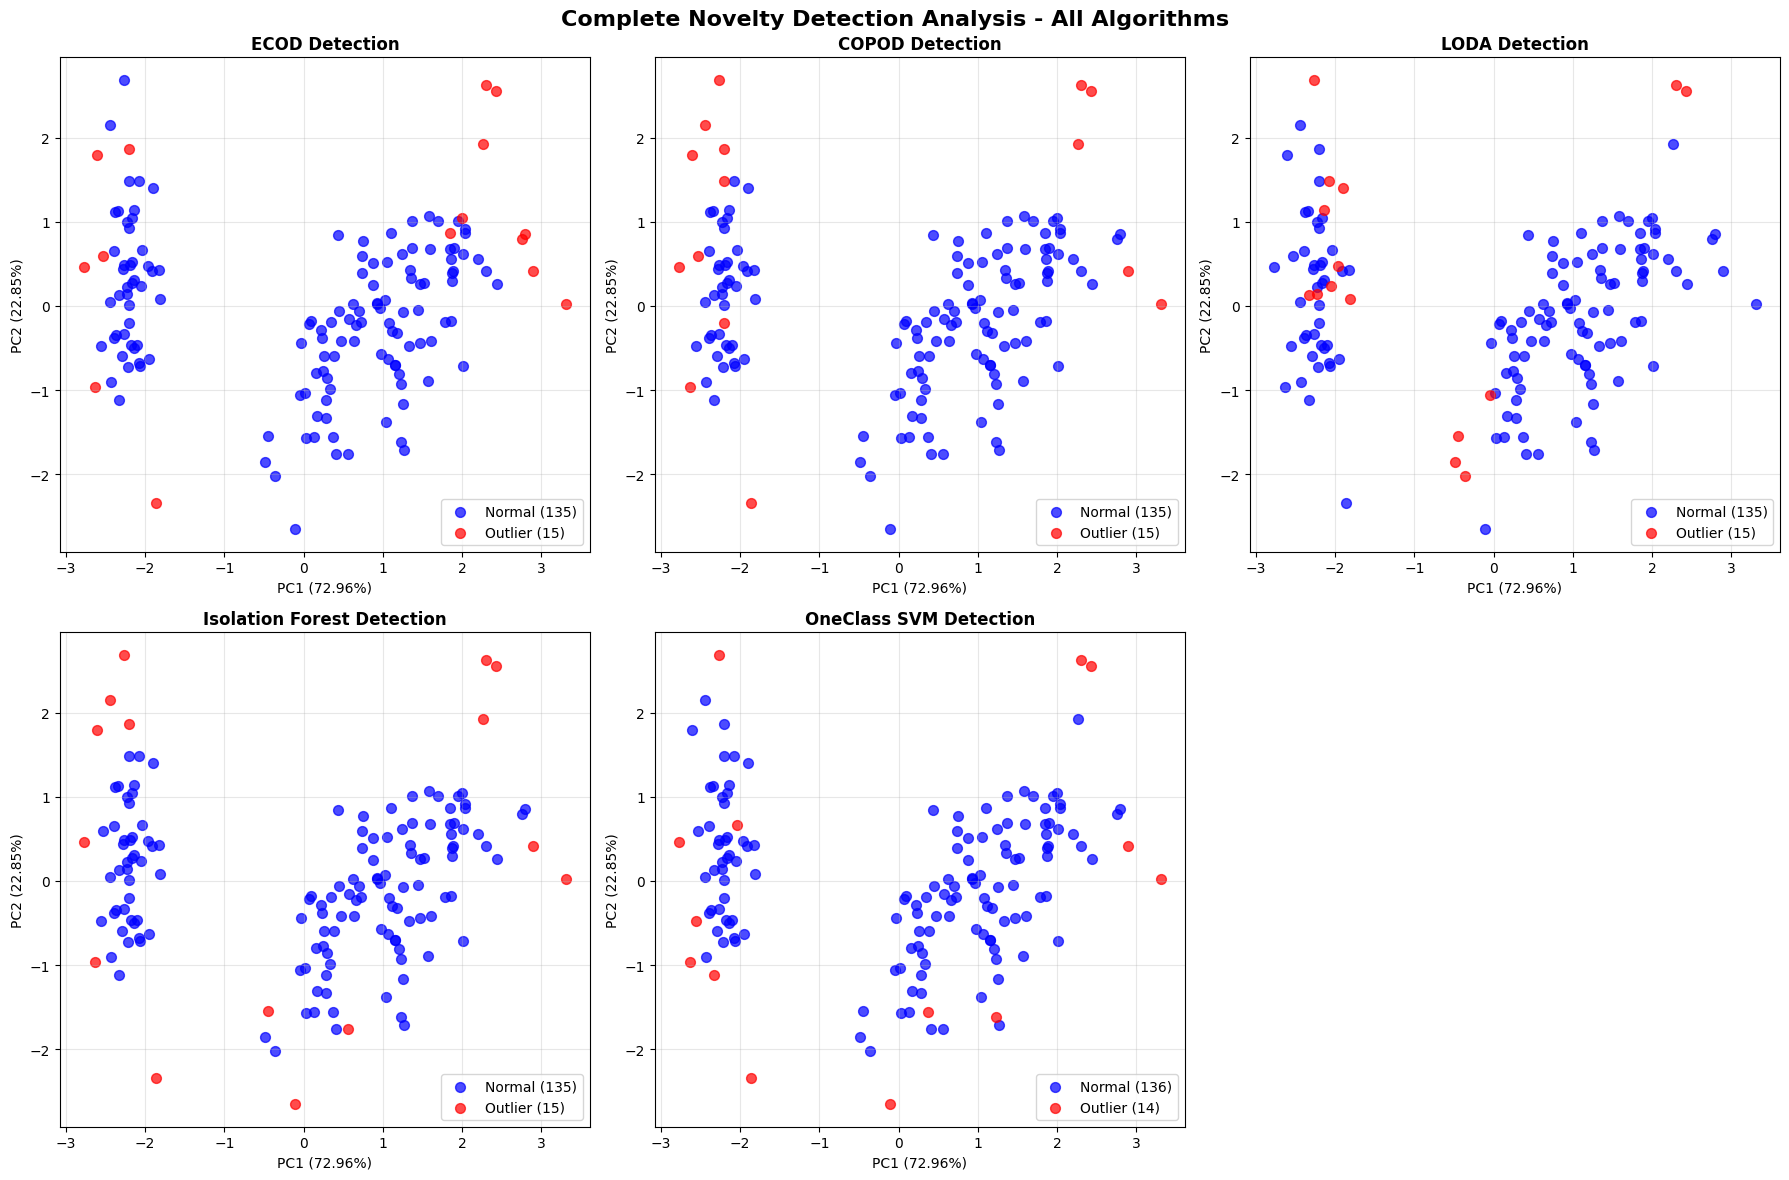

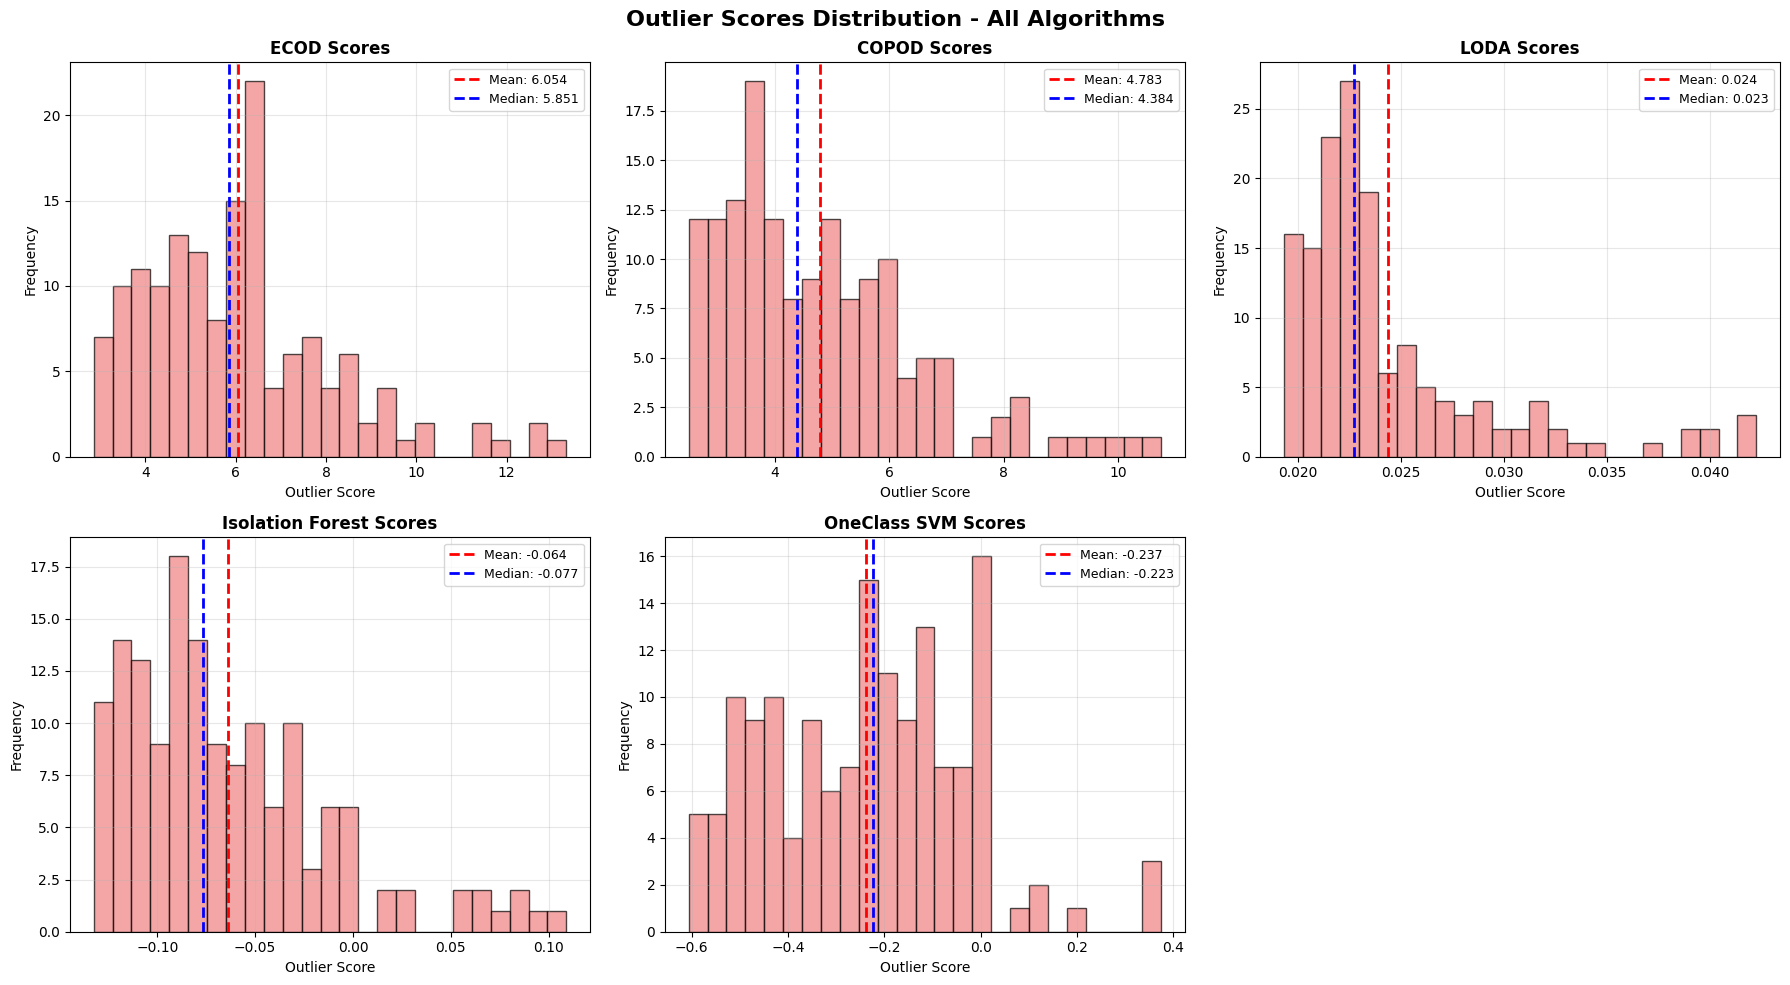

In [14]:

# Import additional algorithms
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Initialize additional models
additional_models = {
    'Isolation_Forest': IsolationForest(contamination=contamination, random_state=42, n_estimators=100),
    'OneClass_SVM': OneClassSVM(gamma='scale', nu=contamination)
}

# Dictionary to store additional results
additional_results = {}

# Train additional models and get predictions
for name, model in additional_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_scaled)
    
    # Get outlier predictions (sklearn returns -1 for outlier, 1 for inlier)
    outlier_pred_raw = model.predict(X_scaled)
    # Convert to pyod format (1 for outlier, 0 for inlier)
    outlier_pred = (outlier_pred_raw == -1).astype(int)
    
    # Get outlier scores
    if hasattr(model, 'decision_function'):
        outlier_scores = model.decision_function(X_scaled)
        # For sklearn, negative scores indicate outliers, so we negate for consistency
        outlier_scores = -outlier_scores
    else:
        outlier_scores = model.score_samples(X_scaled)
        outlier_scores = -outlier_scores  # Negate for consistency
    
    # Store results
    additional_results[name] = {
        'model': model,
        'predictions': outlier_pred,
        'scores': outlier_scores,
        'n_outliers': np.sum(outlier_pred)
    }
    
    print(f"{name} - Number of outliers detected: {additional_results[name]['n_outliers']}")
    print(f"{name} - Outlier percentage: {additional_results[name]['n_outliers']/len(X_scaled)*100:.2f}%")

# Combine all results for comprehensive comparison
all_results = {**results, **additional_results}

# Create visualization for all 5 algorithms
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Complete Novelty Detection Analysis - All Algorithms', fontsize=16, fontweight='bold')

# Plot results for all algorithms
algorithm_names = list(all_results.keys())
colors = ['blue', 'red']
labels = ['Normal', 'Outlier']

for i, (name, result) in enumerate(all_results.items()):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    for j, (color, label) in enumerate(zip(colors, labels)):
        mask = result['predictions'] == j
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c=color, label=f'{label} ({np.sum(mask)})', alpha=0.7, s=50)
    
    ax.set_title(f'{name.replace("_", " ")} Detection', fontweight='bold', fontsize=12)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Remove empty subplot
if len(all_results) < 6:
    axes[1, 2].remove()

plt.tight_layout()
plt.show()

# Create outlier scores comparison for all algorithms
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Outlier Scores Distribution - All Algorithms', fontsize=16, fontweight='bold')

for i, (name, result) in enumerate(all_results.items()):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot histogram of outlier scores
    ax.hist(result['scores'], bins=25, alpha=0.7, color='lightcoral', edgecolor='black')
    ax.axvline(np.mean(result['scores']), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {np.mean(result["scores"]):.3f}')
    ax.axvline(np.median(result['scores']), color='blue', linestyle='--', linewidth=2,
               label=f'Median: {np.median(result["scores"]):.3f}')
    
    ax.set_title(f'{name.replace("_", " ")} Scores', fontweight='bold', fontsize=12)
    ax.set_xlabel('Outlier Score')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Remove empty subplot
if len(all_results) < 6:
    axes[1, 2].remove()

plt.tight_layout()
plt.show()




COMPREHENSIVE ALGORITHM COMPARISON
       Algorithm  Outliers_Detected Outlier_Percentage Mean_Score Std_Score Min_Score Max_Score
            ECOD                 15             10.00%     6.0543    2.1061    2.8585   13.3211
           COPOD                 15             10.00%     4.7831    1.7236    2.4880   10.7589
            LODA                 15             10.00%     0.0244    0.0050    0.0193    0.0423
Isolation Forest                 15             10.00%    -0.0639    0.0524   -0.1325    0.1090
    OneClass SVM                 14              9.33%    -0.2369    0.2045   -0.6061    0.3752


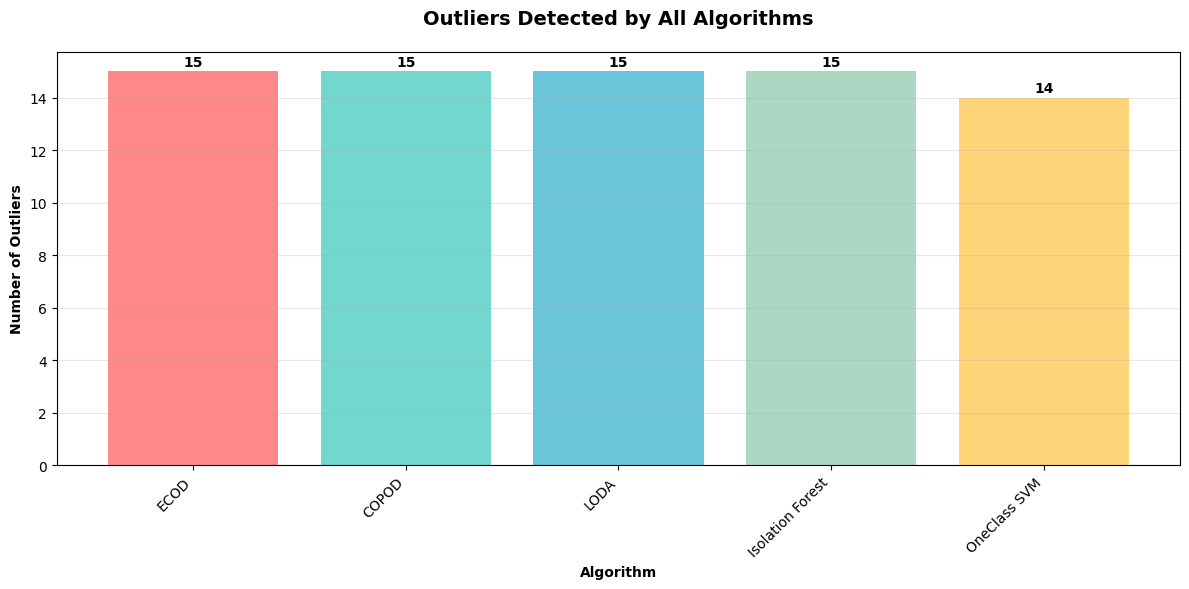

In [15]:
# Updated comprehensive comparison
print("\n" + "="*80)
print("COMPREHENSIVE ALGORITHM COMPARISON")
print("="*80)

comprehensive_df = pd.DataFrame({
    'Algorithm': [name.replace('_', ' ') for name in all_results.keys()],
    'Outliers_Detected': [all_results[name]['n_outliers'] for name in all_results.keys()],
    'Outlier_Percentage': [f"{all_results[name]['n_outliers']/len(X_scaled)*100:.2f}%" for name in all_results.keys()],
    'Mean_Score': [f"{np.mean(all_results[name]['scores']):.4f}" for name in all_results.keys()],
    'Std_Score': [f"{np.std(all_results[name]['scores']):.4f}" for name in all_results.keys()],
    'Min_Score': [f"{np.min(all_results[name]['scores']):.4f}" for name in all_results.keys()],
    'Max_Score': [f"{np.max(all_results[name]['scores']):.4f}" for name in all_results.keys()]
})

print(comprehensive_df.to_string(index=False))

# Algorithm performance comparison chart
plt.figure(figsize=(12, 6))
algorithm_display_names = [name.replace('_', ' ') for name in all_results.keys()]
outlier_counts_all = [all_results[name]['n_outliers'] for name in all_results.keys()]

colors_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
bars = plt.bar(algorithm_display_names, outlier_counts_all, 
               color=colors_palette[:len(algorithm_display_names)], alpha=0.8)

plt.title('Outliers Detected by All Algorithms', fontweight='bold', fontsize=14, pad=20)
plt.ylabel('Number of Outliers', fontweight='bold')
plt.xlabel('Algorithm', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, count in zip(bars, outlier_counts_all):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



In [16]:
# Extended consensus analysis
print("\n" + "="*80)
print("EXTENDED CONSENSUS ANALYSIS")
print("="*80)

# Create prediction matrix for all algorithms
all_pred_matrix = np.column_stack([all_results[name]['predictions'] for name in all_results.keys()])
all_consensus_outliers = np.sum(all_pred_matrix, axis=1)

print("Extended consensus outlier detection (5 algorithms):")
for i in range(6):
    count = np.sum(all_consensus_outliers == i)
    if count > 0:
        if i == 0:
            print(f"Samples detected as normal by ALL algorithms: {count}")
        elif i == 5:
            print(f"Samples detected as outliers by ALL 5 algorithms: {count}")
        else:
            print(f"Samples detected as outliers by {i} algorithm(s): {count}")

# Show samples with highest consensus
max_consensus = np.max(all_consensus_outliers)
if max_consensus >= 3:
    high_consensus_idx = np.where(all_consensus_outliers >= 3)[0]
    print(f"\nSamples detected as outliers by 3+ algorithms (indices): {high_consensus_idx}")
    if len(high_consensus_idx) > 0:
        print("Details of these high-consensus outliers:")
        consensus_details = df.iloc[high_consensus_idx][['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width', 'Species']]
        consensus_details['Consensus_Count'] = all_consensus_outliers[high_consensus_idx]
        print(consensus_details.to_string())




EXTENDED CONSENSUS ANALYSIS
Extended consensus outlier detection (5 algorithms):
Samples detected as normal by ALL algorithms: 112
Samples detected as outliers by 1 algorithm(s): 23
Samples detected as outliers by 2 algorithm(s): 4
Samples detected as outliers by 3 algorithm(s): 3
Samples detected as outliers by 4 algorithm(s): 6
Samples detected as outliers by ALL 5 algorithms: 2

Samples detected as outliers by 3+ algorithms (indices): [ 13  14  15  22  32  41 109 117 118 122 131]
Details of these high-consensus outliers:
     Sepal.Length  Sepal.Width  Petal.Length  Petal.Width    Species  Consensus_Count
13            4.3          3.0           1.1          0.1     setosa                4
14            5.8          4.0           1.2          0.2     setosa                3
15            5.7          4.4           1.5          0.4     setosa                4
22            4.6          3.6           1.0          0.2     setosa                4
32            5.2          4.1         


EXTENDED SCORE CORRELATION ANALYSIS
Correlation matrix of outlier scores (all algorithms):
                    ECOD   COPOD    LODA  Isolation Forest  OneClass SVM
ECOD              1.0000  0.9183  0.2765            0.7592        0.5151
COPOD             0.9183  1.0000  0.2980            0.6936        0.5816
LODA              0.2765  0.2980  1.0000            0.5720        0.3325
Isolation Forest  0.7592  0.6936  0.5720            1.0000        0.6311
OneClass SVM      0.5151  0.5816  0.3325            0.6311        1.0000


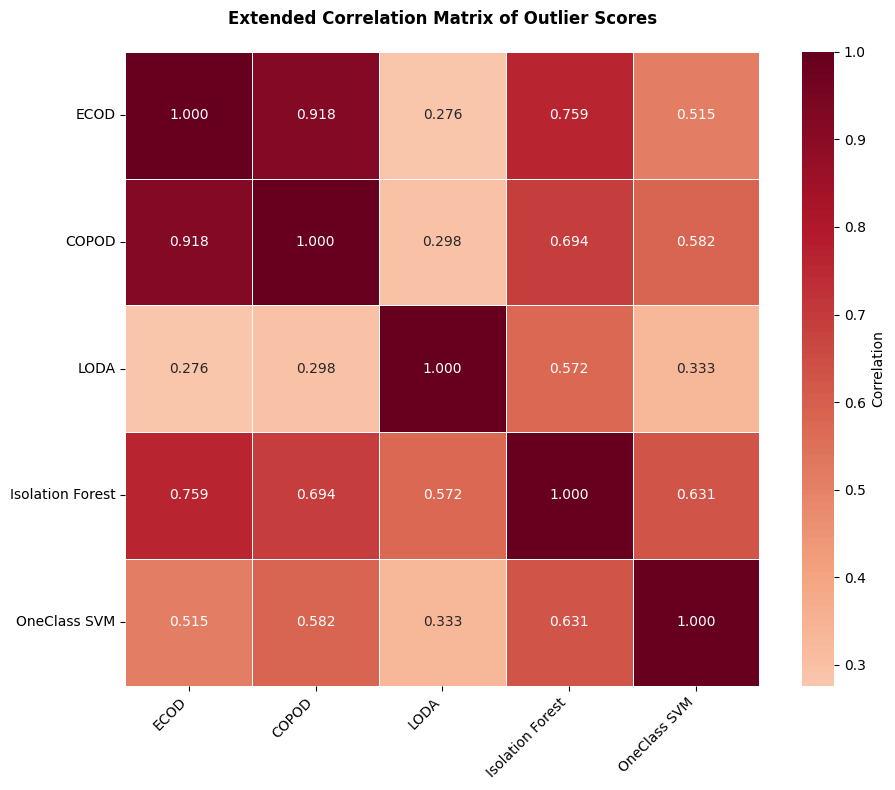

In [18]:
# Extended correlation analysis
print("\n" + "="*80)
print("EXTENDED SCORE CORRELATION ANALYSIS")
print("="*80)

all_score_df = pd.DataFrame({name.replace('_', ' '): all_results[name]['scores'] for name in all_results.keys()})
all_correlation_matrix = all_score_df.corr()

print("Correlation matrix of outlier scores (all algorithms):")
print(all_correlation_matrix.round(4))

# Plot extended correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(all_correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation'},
            linewidths=0.5)
plt.title('Extended Correlation Matrix of Outlier Scores', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [19]:
# Algorithm characteristics summary
print("\n" + "="*80)
print("ALGORITHM CHARACTERISTICS SUMMARY")
print("="*80)

characteristics = {
    'ECOD': 'Empirical Cumulative Distribution - Fast, parameter-free',
    'COPOD': 'Copula-based - Handles complex dependencies',
    'LODA': 'Lightweight Online - Efficient for streaming data',
    'Isolation_Forest': 'Tree-based isolation - Good for high-dimensional data',
    'OneClass_SVM': 'Support Vector Machine - Effective decision boundaries'
}

for alg, desc in characteristics.items():
    if alg in all_results:
        outliers = all_results[alg]['n_outliers']
        print(f"{alg.replace('_', ' ')}: {desc}")
        print(f"  → Detected {outliers} outliers ({outliers/len(X_scaled)*100:.1f}%)")
        print()

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("Summary:")
print("- Isolation Forest: Tree-based ensemble approach")
print("- One-Class SVM: Support vector machine approach")


ALGORITHM CHARACTERISTICS SUMMARY
ECOD: Empirical Cumulative Distribution - Fast, parameter-free
  → Detected 15 outliers (10.0%)

COPOD: Copula-based - Handles complex dependencies
  → Detected 15 outliers (10.0%)

LODA: Lightweight Online - Efficient for streaming data
  → Detected 15 outliers (10.0%)

Isolation Forest: Tree-based isolation - Good for high-dimensional data
  → Detected 15 outliers (10.0%)

OneClass SVM: Support Vector Machine - Effective decision boundaries
  → Detected 14 outliers (9.3%)


ANALYSIS COMPLETE
Summary:
- Isolation Forest: Tree-based ensemble approach
- One-Class SVM: Support vector machine approach
